In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import logging

logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# MLflow setup: use service name when running inside docker compose
if os.getenv("DOCKER_ENV"):
    tracking_uri = "http://mlflow:5000"
else:
    tracking_uri = "http://localhost:5000"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Forecasting Models")

print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025/08/17 12:51:39 INFO mlflow.tracking.fluent: Experiment with name 'Forecasting Models' does not exist. Creating a new experiment.


MLflow tracking URI set to: http://mlflow:5000


In [2]:
df = pd.read_csv('data/sensor_data.csv', parse_dates=['timestamp'])

# Ensure timestamps are timezone-naive (Prophet requirement)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)

# --- Prepare data for a single sensor ---
sensor_id_to_forecast = 'sensor-001'
df_sensor = df[df['sensor_id'] == sensor_id_to_forecast].copy()

# Prophet requires columns to be named 'ds' (datestamp) and 'y' (value)
df_prophet = df_sensor[['timestamp', 'value']].rename(columns={'timestamp': 'ds', 'value': 'y'})

# --- Train/Test Split ---
split_point = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_point]
test_df = df_prophet.iloc[split_point:]

print(f"Forecasting for sensor: {sensor_id_to_forecast}")
print(f"Train size: {train_df.shape[0]}, Test size: {test_df.shape[0]}")

Forecasting for sensor: sensor-001
Train size: 480, Test size: 120


12:51:39 - cmdstanpy - INFO - Chain [1] start processing


12:51:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 2.8402 | Naive MAE: 3.5704 | SMAPE: 0.0468 | Coverage: 0.742


2025/08/17 12:51:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully registered model 'prophet_forecaster_enhanced_sensor-001'.
2025/08/17 12:51:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_forecaster_enhanced_sensor-001, version 1


Created version '1' of model 'prophet_forecaster_enhanced_sensor-001'.


Run complete. Model registered as 'prophet_forecaster_enhanced_sensor-001'.
🏃 View run Prophet_v2_Enhanced_sensor-001 at: http://mlflow:5000/#/experiments/2/runs/b491946bec3c4decbee1cac61a935ecb
🧪 View experiment at: http://mlflow:5000/#/experiments/2


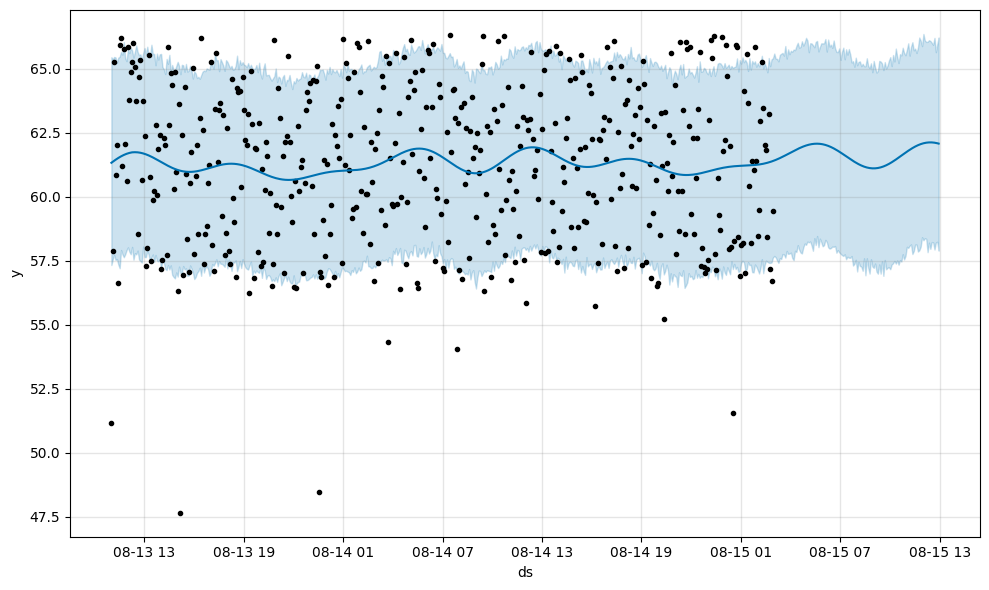

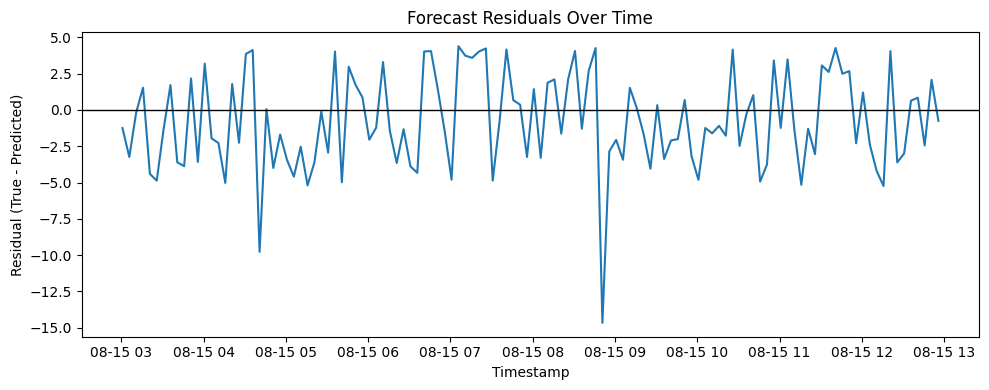

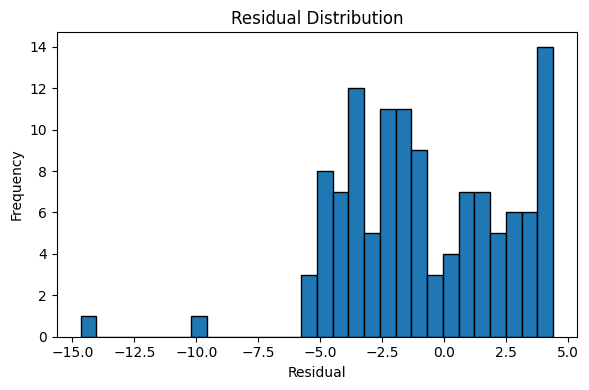

In [3]:
import pathlib
pathlib.Path("docs/ml").mkdir(parents=True, exist_ok=True)

with mlflow.start_run(run_name=f"Prophet_v2_Enhanced_{sensor_id_to_forecast}") as run:
    mlflow.log_param("sensor_id", sensor_id_to_forecast)
    mlflow.log_param("model_type", "Prophet_v2")
    mlflow.log_param("train_test_split", 0.8)

    # --- Train Model ---
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
    model.fit(train_df)

    # --- Make future predictions ---
    future_df = model.make_future_dataframe(periods=len(test_df), freq='5min')
    forecast_df = model.predict(future_df)

    # --- Evaluate Model ---
    y_true = test_df['y'].values
    y_pred = forecast_df['yhat'][-len(test_df):].values
    y_lower = forecast_df['yhat_lower'][-len(test_df):].values
    y_upper = forecast_df['yhat_upper'][-len(test_df):].values
    residuals = y_true - y_pred

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    smape = (2 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)))
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))

    # Naive baseline (last observed value persistence)
    naive_pred = np.roll(test_df['y'].values, 1)
    naive_pred[0] = train_df['y'].iloc[-1]
    naive_mae = mean_absolute_error(y_true, naive_pred)

    # Residual autocorrelation (lag 1) safe guard for constant residuals
    if len(residuals) > 1:
        resid_autocorr_lag1 = float(np.corrcoef(residuals[1:], residuals[:-1])[0,1])
    else:
        resid_autocorr_lag1 = 0.0

    mlflow.log_metrics({
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "smape": smape,
        "coverage": coverage,
        "naive_mae": naive_mae,
        "resid_autocorr_lag1": resid_autocorr_lag1
    })

    print(f"Prophet MAE: {mae:.4f} | Naive MAE: {naive_mae:.4f} | SMAPE: {smape:.4f} | Coverage: {coverage:.3f}")

    # --- Log Model and Artifacts ---
    mlflow.prophet.log_model(model, "model", registered_model_name=f"prophet_forecaster_enhanced_{sensor_id_to_forecast}")

    # Forecast Plot
    fig1 = model.plot(forecast_df)
    fig1.savefig("docs/ml/forecast_plot_v2.png")
    mlflow.log_artifact("docs/ml/forecast_plot_v2.png", "plots")

    # Residuals Plot
    plt.figure(figsize=(10, 4))
    plt.plot(test_df['ds'], residuals, label='Residual')
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Forecast Residuals Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Residual (True - Predicted)')
    plt.tight_layout()
    plt.savefig("docs/ml/residuals_plot.png")
    mlflow.log_artifact("docs/ml/residuals_plot.png", "plots")

    # Residual distribution
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Residual Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig("docs/ml/residuals_hist.png")
    mlflow.log_artifact("docs/ml/residuals_hist.png", "plots")

    print(f"Run complete. Model registered as 'prophet_forecaster_enhanced_{sensor_id_to_forecast}'.")